# Deep Learning Model Definition and Training

Notably, this is not the final model. This can be considered more of a toy model which regresses numerical values. However, as we wish to regress cateogircal data, this is more of a starting point.

## Download and load libraries and datasets

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pickle

In [ ]:
!gdown https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f

Downloading...
From: https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f
To: /content/CrimeData
100% 15.5M/15.5M [00:00<00:00, 48.3MB/s]


In [ ]:
# Load Data
file_path = 'CrimeData'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

data = data.sample(n=5000, random_state=42)

data = data.rename(columns={'date': 'ds', 'value': 'y'})
data.ds = pd.to_datetime(data.ds)
crime_counts = data.groupby('ds').size().reset_index(name='count')
crime_counts = crime_counts.rename(columns={'count': 'y'})


## Define Numerical Model that uses LSTM

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnjcdz52d/mn7apjpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnjcdz52d/hxs5b13s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41047', 'data', 'file=/tmp/tmpnjcdz52d/mn7apjpk.json', 'init=/tmp/tmpnjcdz52d/hxs5b13s.json', 'output', 'file=/tmp/tmpnjcdz52d/prophet_modelv3qecg8a/prophet_model-20241114190826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


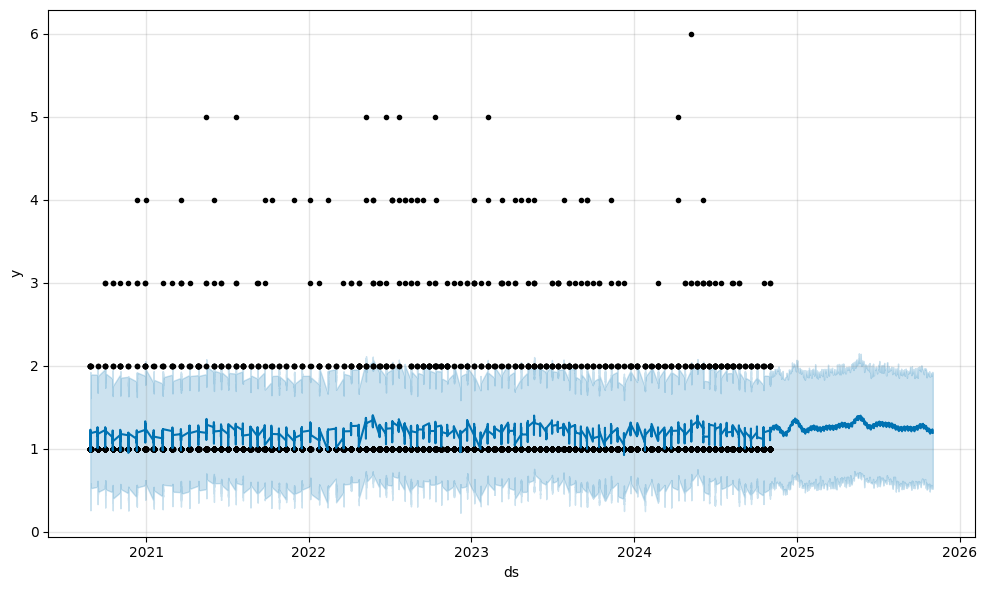

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pickle


prophet_model = Prophet()
prophet_model.fit(crime_counts)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

# Plot forecast
fig = prophet_model.plot(forecast)
plt.show()

# Prepare data for LSTM
forecast_data = forecast[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'value'})
forecast_data.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(forecast_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

## Define predict and graph to evaluate the model

In [ ]:
def predict_and_graph(model, X_test, y_test):
    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    # Plot the results
    train = forecast_data.iloc[:split + seq_length]
    valid = forecast_data.iloc[split + seq_length:]
    valid = valid.iloc[:len(predictions)]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.plot(train['value'])
    plt.plot(valid[['value', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

## Consider different permutations of optimizers and mini-batch to evaluate the effect of batches and optimizers on performance

Notably, analysis not provided since this is not the final model we decided to evaluate

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - loss: 0.0034
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


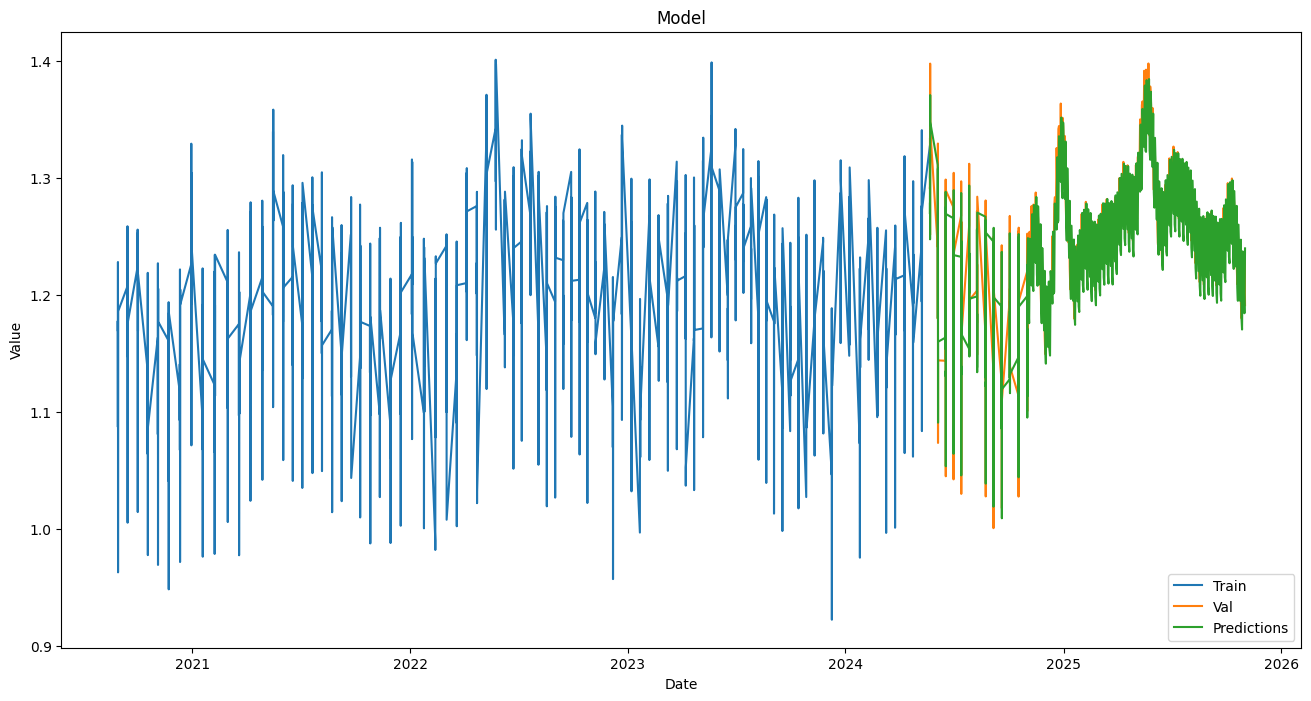

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 117s 32ms/step - loss: 0.0035
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


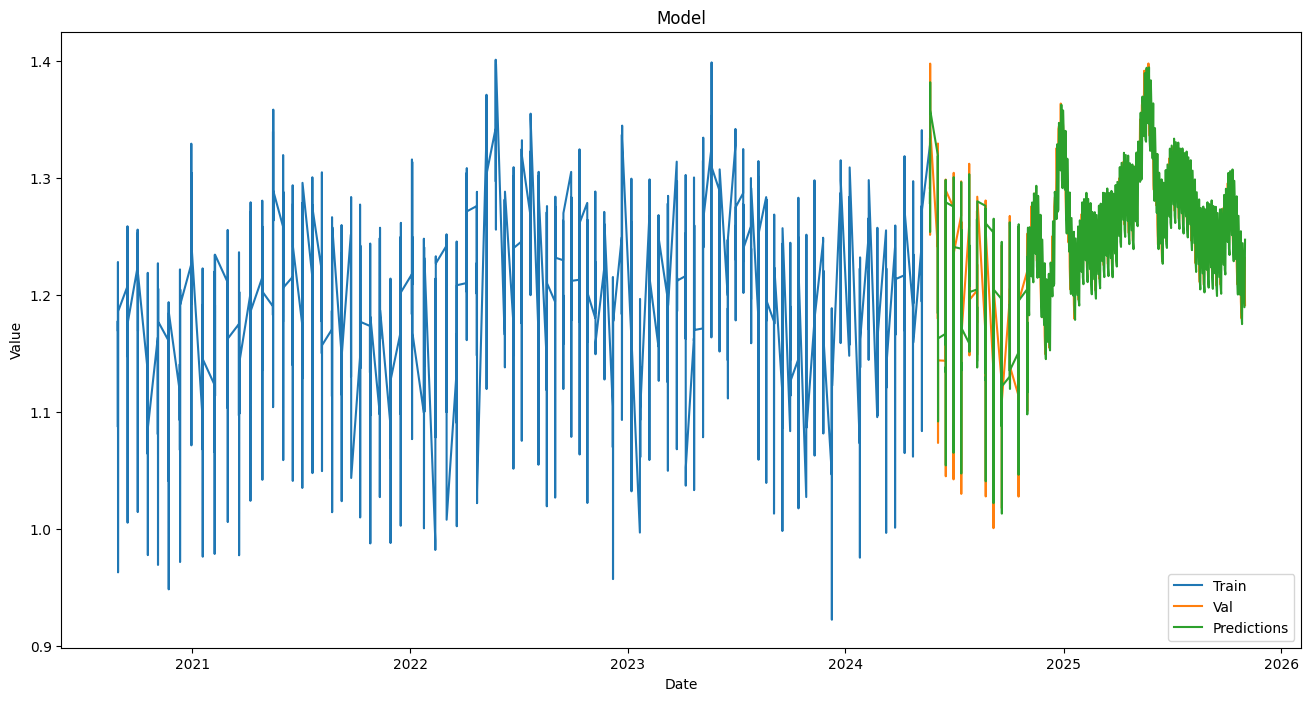

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0032
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


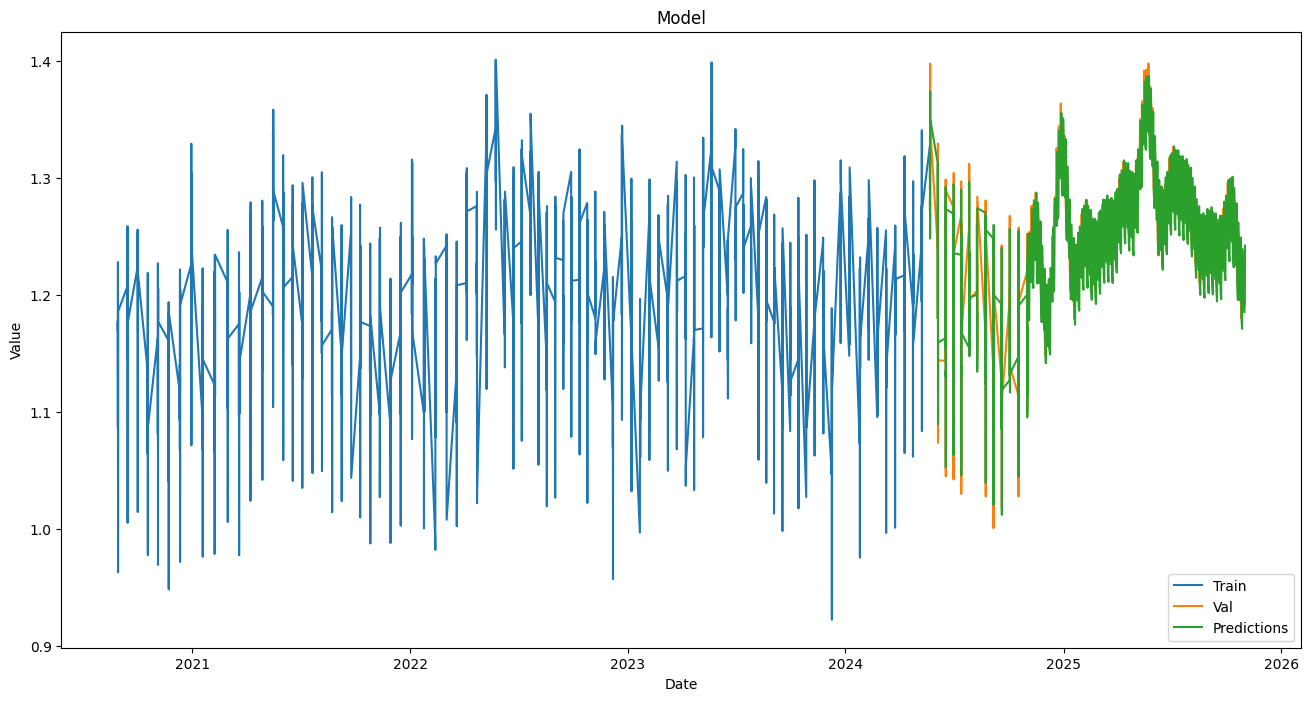

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0032
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


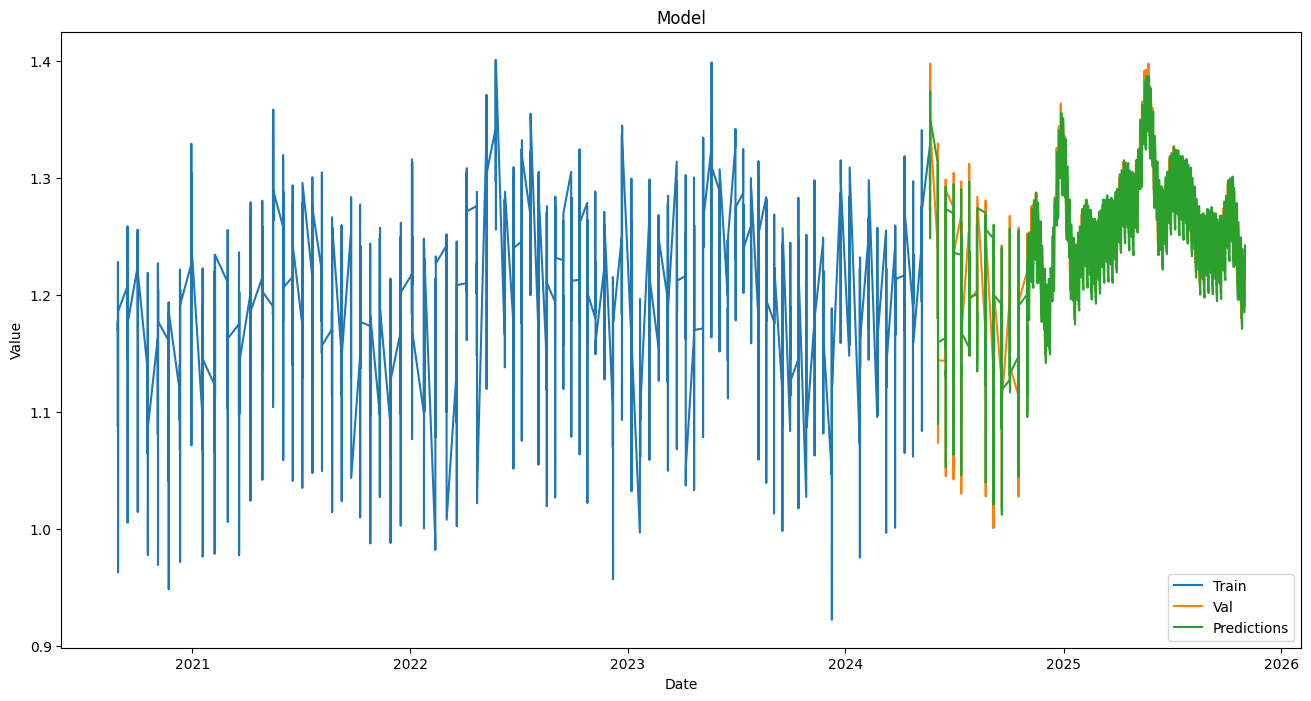

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025


,optimizer,batch,batch size,eval
0,adam,True,1,0.003639
1,SGD,True,1,0.003481
2,adam,False,3595,0.003572
3,SGD,False,3595,0.003566


In [ ]:
optimizers = ['adam', 'SGD']
batches = [True, False]

performances = []

zip_params = np.transpose([np.tile(optimizers, len(batches)), np.repeat(batches, len(optimizers))])
for optimizer, batch in zip_params:
  if batch == "True":
    batch_size = 1
  else:
    batch_size = len(y_train)

  # Compile the model
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  # Train the model
  model.fit(X_train, y_train, batch_size=batch_size, epochs=1)

  predict_and_graph(model, X_test, y_test)

  performances.append({"optimizer": optimizer, "batch": batch, "batch size": batch_size, "eval": model.evaluate(X_test, y_test)})

perf_df = pd.DataFrame(performances)
perf_df